In [22]:
import io
import textwrap

import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import matplotlib.pyplot as plt

gppd.set_interactive()

In [23]:
########
# Data schema
#
# Each generator has properties which remain fixed over all time periods
#
# - num_available: number of available generating units
# - min_output: minimum generation in MWh for each active generator
# - max_output: maximum generation in MWh for each active generator
# - cost_per_hour: $ cost per hour per active generator
# - marginal cost: cost in $/MWh for generation above min_output
# - startup_cost: fixed cost incurred for starting a generator in an interval
# - state0: number of generators active before the first period
#
# Each time period has the following data
#
# - expected_demand: predicted MWh demand, which the solution will meet exactly
# - minimum_capacity: value in MWh above the predicted demand; the total online
#                     generation capacity must exceed this value
#
########

generator_data = pd.read_csv(
    io.StringIO(
        textwrap.dedent(
            """
            generator_class,num_available,min_output,max_output,cost_per_hour,marginal_cost,startup_cost,state0
            thermal1,12,850.0,2000.0,1000.0,2.0,2000.0,0
            thermal2,10,1250.0,1750.0,2600.0,1.30,1000.0,0
            thermal3,5,1500.0,4000.0,3000.0,3.0,500.0,0
            """
        )
    ),
    index_col=0,
)

time_period_data = (
    pd.read_csv(
        io.StringIO(
            textwrap.dedent(
                """
                time_period,expected_demand,minimum_active_capacity
                0,15000.0,17250.0
                1,30000.0,34500.0
                2,25000.0,28750.0
                3,40000.0,46000.0
                4,27000.0,31050.0
                """
            )
        )
    )
    .assign(
        time_period=pd.date_range(
            pd.Timestamp("2024-07-19 06:00:00"), freq="h", periods=5
        )
    )
    .set_index("time_period")
)

In [24]:
generator_data

,num_available,min_output,max_output,cost_per_hour,marginal_cost,startup_cost,state0
generator_class,,,,,,,
thermal1,12,850.0,2000.0,1000.0,2.0,2000.0,0
thermal2,10,1250.0,1750.0,2600.0,1.3,1000.0,0
thermal3,5,1500.0,4000.0,3000.0,3.0,500.0,0


In [25]:
time_period_data

,expected_demand,minimum_active_capacity
time_period,,
2024-07-19 06:00:00,15000.0,17250.0
2024-07-19 07:00:00,30000.0,34500.0
2024-07-19 08:00:00,25000.0,28750.0
2024-07-19 09:00:00,40000.0,46000.0
2024-07-19 10:00:00,27000.0,31050.0


In [26]:
# Set up variables based on the data schema
#
# For each generator type, we have three classes of variables:
#
# - The total output of all generators in the class in the given time
#   period (continuous)
# - The number of active generators of the class in the given time period
#   (integer, upper bounded by number of available generators)
# - The number of active generators of the class which start up in the
#   given time period (integer)
#
# One variable is required for every generator class and time period

env = gp.Env()
model = gp.Model(env=env)

# Method chain our way to creating these variable sets.
# We need to create a dense index: generators x time periods.

index_formatter = {"time_period": lambda index: index.strftime("%H%M")}
generators = (
    pd.DataFrame(
        index=pd.MultiIndex.from_product([generator_data.index, time_period_data.index])
    )
    .join(generator_data)
    .gppd.add_vars(model, name="output", index_formatter=index_formatter)
    .gppd.add_vars(
        model,
        vtype=GRB.INTEGER,
        ub="num_available",
        name="num_active",
        index_formatter=index_formatter,
    )
    .gppd.add_vars(
        model, vtype=GRB.INTEGER, name="num_startup", index_formatter=index_formatter
    )
)

In [27]:
# Just show a subset of the time-expanded dataframe
(
    generators[["output", "num_active", "num_startup", "cost_per_hour", "startup_cost", "min_output", "max_output"]]
    .assign(
        output=lambda df: df["output"].gppd.VarName,
        num_active=lambda df: df["num_active"].gppd.VarName,
        num_startup=lambda df: df["num_startup"].gppd.VarName,
    )
)

output  \
generator_class time_period                                  
thermal1        2024-07-19 06:00:00  output[thermal1,0600]   
                2024-07-19 07:00:00  output[thermal1,0700]   
                2024-07-19 08:00:00  output[thermal1,0800]   
                2024-07-19 09:00:00  output[thermal1,0900]   
                2024-07-19 10:00:00  output[thermal1,1000]   
thermal2        2024-07-19 06:00:00  output[thermal2,0600]   
                2024-07-19 07:00:00  output[thermal2,0700]   
                2024-07-19 08:00:00  output[thermal2,0800]   
                2024-07-19 09:00:00  output[thermal2,0900]   
                2024-07-19 10:00:00  output[thermal2,1000]   
thermal3        2024-07-19 06:00:00  output[thermal3,0600]   
                2024-07-19 07:00:00  output[thermal3,0700]   
                2024-07-19 08:00:00  output[thermal3,0800]   
                2024-07-19 09:00:00  output[thermal3,0900]   
                2024-07-19 10:00:00  output[thermal3,1000]   

                                                    num_active  \
generator_class time_period                                      
thermal1        2024-07-19 06:00:00  num_active[thermal1,0600]   
                2024-07-19 07:00:00  num_active[thermal1,0700]   
                2024-07-19 08:00:00  num_active[thermal1,0800]   
                2024-07-19 09:00:00  num_active[thermal1,0900]   
                2024-07-19 10:00:00  num_active[thermal1,1000]   
thermal2        2024-07-19 06:00:00  num_active[thermal2,0600]   
                2024-07-19 07:00:00  num_active[thermal2,0700]   
                2024-07-19 08:00:00  num_active[thermal2,0800]   
                2024-07-19 09:00:00  num_active[thermal2,0900]   
                2024-07-19 10:00:00  num_active[thermal2,1000]   
thermal3        2024-07-19 06:00:00  num_active[thermal3,0600]   
                2024-07-19 07:00:00  num_active[thermal3,0700]   
                2024-07-19 08:00:00  num_active[thermal3,0800]   
                2024-07-19 09:00:00  num_active[thermal3,0900]   
                2024-07-19 10:00:00  num_active[thermal3,1000]   

                                                    num_startup  \
generator_class time_period                                       
thermal1        2024-07-19 06:00:00  num_startup[thermal1,0600]   
                2024-07-19 07:00:00  num_startup[thermal1,0700]   
                2024-07-19 08:00:00  num_startup[thermal1,0800]   
                2024-07-19 09:00:00  num_startup[thermal1,0900]   
                2024-07-19 10:00:00  num_startup[thermal1,1000]   
thermal2        2024-07-19 06:00:00  num_startup[thermal2,0600]   
                2024-07-19 07:00:00  num_startup[thermal2,0700]   
                2024-07-19 08:00:00  num_startup[thermal2,0800]   
                2024-07-19 09:00:00  num_startup[thermal2,0900]   
                2024-07-19 10:00:00  num_startup[thermal2,1000]   
thermal3        2024-07-19 06:00:00  num_startup[thermal3,0600]   
                2024-07-19 07:00:00  num_startup[thermal3,0700]   
                2024-07-19 08:00:00  num_startup[thermal3,0800]   
                2024-07-19 09:00:00  num_startup[thermal3,0900]   
                2024-07-19 10:00:00  num_startup[thermal3,1000]   

                                     cost_per_hour  startup_cost  min_output  \
generator_class time_period                                                    
thermal1        2024-07-19 06:00:00         1000.0        2000.0       850.0   
                2024-07-19 07:00:00         1000.0        2000.0       850.0   
                2024-07-19 08:00:00         1000.0        2000.0       850.0   
                2024-07-19 09:00:00         1000.0        2000.0       850.0   
                2024-07-19 10:00:00         1000.0        2000.0       850.0   
thermal2        2024-07-19 06:00:00         2600.0        1000.0      1250.0   
                2024-07-19 07:00:00         2600.0        1000.0      1250.0   
              

In [28]:
# Constrain that predicted demand is exactly satisfied
demand_constraint = gppd.add_constrs(
    model,
    generators.groupby("time_period")["output"].sum(),
    GRB.EQUAL,
    time_period_data["expected_demand"],
)

In [29]:
df = (
    generators
    .gppd.add_constrs(
        model,
        "output >= min_output * num_active",
        name="lower_limit",
        index_formatter=index_formatter
    )
    .gppd.add_constrs(
        model,
        "output <= max_output * num_active",
        name="constr_max_output",
        index_formatter=index_formatter
    )
)

(
    df[["output", "num_active", "min_output", "max_output", "lower_limit"]]
    .assign(
        output=lambda df: df["output"].gppd.VarName,
        num_active=lambda df: df["num_active"].gppd.VarName,
        # lower_limit=lambda df: df["lower_limit"].gppd.ConstrName,
    )
)

output  \
generator_class time_period                                  
thermal1        2024-07-19 06:00:00  output[thermal1,0600]   
                2024-07-19 07:00:00  output[thermal1,0700]   
                2024-07-19 08:00:00  output[thermal1,0800]   
                2024-07-19 09:00:00  output[thermal1,0900]   
                2024-07-19 10:00:00  output[thermal1,1000]   
thermal2        2024-07-19 06:00:00  output[thermal2,0600]   
                2024-07-19 07:00:00  output[thermal2,0700]   
                2024-07-19 08:00:00  output[thermal2,0800]   
                2024-07-19 09:00:00  output[thermal2,0900]   
                2024-07-19 10:00:00  output[thermal2,1000]   
thermal3        2024-07-19 06:00:00  output[thermal3,0600]   
                2024-07-19 07:00:00  output[thermal3,0700]   
                2024-07-19 08:00:00  output[thermal3,0800]   
                2024-07-19 09:00:00  output[thermal3,0900]   
                2024-07-19 10:00:00  output[thermal3,1000]   

                                                    num_active  min_output  \
generator_class time_period                                                  
thermal1        2024-07-19 06:00:00  num_active[thermal1,0600]       850.0   
                2024-07-19 07:00:00  num_active[thermal1,0700]       850.0   
                2024-07-19 08:00:00  num_active[thermal1,0800]       850.0   
                2024-07-19 09:00:00  num_active[thermal1,0900]       850.0   
                2024-07-19 10:00:00  num_active[thermal1,1000]       850.0   
thermal2        2024-07-19 06:00:00  num_active[thermal2,0600]      1250.0   
                2024-07-19 07:00:00  num_active[thermal2,0700]      1250.0   
                2024-07-19 08:00:00  num_active[thermal2,0800]      1250.0   
                2024-07-19 09:00:00  num_active[thermal2,0900]      1250.0   
                2024-07-19 10:00:00  num_active[thermal2,1000]      1250.0   
thermal3        2024-07-19 06:00:00  num_active[thermal3,0600]      1500.0   
                2024-07-19 07:00:00  num_active[thermal3,0700]      1500.0   
                2024-07-19 08:00:00  num_active[thermal3,0800]      1500.0   
                2024-07-19 09:00:00  num_active[thermal3,0900]      1500.0   
                2024-07-19 10:00:00  num_active[thermal3,1000]      1500.0   

                                     max_output  \
generator_class time_period                       
thermal1        2024-07-19 06:00:00      2000.0   
                2024-07-19 07:00:00      2000.0   
                2024-07-19 08:00:00      2000.0   
                2024-07-19 09:00:00      2000.0   
                2024-07-19 10:00:00      2000.0   
thermal2        2024-07-19 06:00:00      1750.0   
                2024-07-19 07:00:00      1750.0   
                2024-07-19 08:00:00      1750.0   
                2024-07-19 09:00:00      1750.0   
                2024-07-19 10:00:00      1750.0   
thermal3        2024-07-19 06:00:00      4000.0   
                2024-07-19 07:00:00      4000.0   
                2024-07-19 08:00:00      4000.0   
                2024-07-19 09:00:00      4000.0   
                2024-07-19 10:00:00      4000.0   

                                                                    lower_limit  
generator_class time_period                                                      
thermal1        2024-07-19 06:00:00  <gurobi.Constr lower_limit[thermal1,0600]>  
                2024-07-19 07:00:00  <gurobi.Constr lower_limit[thermal1,0700]>  
                2024-07-19 08:00:00  <gurobi.Constr lower_limit[thermal1,0800]>  
                2024-07-19 09:00:00  <gurobi.Constr lower_limit[thermal1,0900]>  
                2024-07-19 10:00:00  <gurobi.Constr lower_limit[thermal1,1000]>  
thermal2        2024-07-19 06:00:00  <gurobi.Constr lower_limit[thermal2,0600]>  
                2024-07-19 07:00:00  <gurobi.Constr lower_limit[thermal2,0700]>  
                2024-07-19 08:00:00  <gurobi.Constr lower_limit[

In [30]:
# Constrain that generators are producing between their minimum and maximum
min_output_constraint = gppd.add_constrs(
    model,
    generators["output"],
    GRB.GREATER_EQUAL,
    generators["min_output"] * generators["num_active"],
    name="min_output",
)
max_output_constraint = gppd.add_constrs(
    model,
    generators["output"],
    GRB.LESS_EQUAL,
    generators["max_output"] * generators["num_active"],
    name="max_output",
)

In [31]:
# Constrain that the active generators during each time
# period are capable of meeting the reserve demand.
active_capacity = (
    (generators["max_output"] * generators["num_active"])
    .groupby("time_period").sum()
)
active_capacity_constraint = gppd.add_constrs(
    model,
    active_capacity,
    GRB.GREATER_EQUAL,
    time_period_data["minimum_active_capacity"],
)

In [41]:
active_capacity.to_frame()

,0
time_period,
2024-07-19 06:00:00,"2000.0 num_active[thermal1,0600] + 1750.0 num_..."
2024-07-19 07:00:00,"2000.0 num_active[thermal1,0700] + 1750.0 num_..."
2024-07-19 08:00:00,"2000.0 num_active[thermal1,0800] + 1750.0 num_..."
2024-07-19 09:00:00,"2000.0 num_active[thermal1,0900] + 1750.0 num_..."
2024-07-19 10:00:00,"2000.0 num_active[thermal1,1000] + 1750.0 num_..."


In [33]:
(
    generators[["num_active", "num_startup"]]
    .assign(
        num_active=lambda df: df["num_active"].gppd.VarName,
        num_startup=lambda df: df["num_startup"].gppd.VarName,
    )
)

num_active  \
generator_class time_period                                      
thermal1        2024-07-19 06:00:00  num_active[thermal1,0600]   
                2024-07-19 07:00:00  num_active[thermal1,0700]   
                2024-07-19 08:00:00  num_active[thermal1,0800]   
                2024-07-19 09:00:00  num_active[thermal1,0900]   
                2024-07-19 10:00:00  num_active[thermal1,1000]   
thermal2        2024-07-19 06:00:00  num_active[thermal2,0600]   
                2024-07-19 07:00:00  num_active[thermal2,0700]   
                2024-07-19 08:00:00  num_active[thermal2,0800]   
                2024-07-19 09:00:00  num_active[thermal2,0900]   
                2024-07-19 10:00:00  num_active[thermal2,1000]   
thermal3        2024-07-19 06:00:00  num_active[thermal3,0600]   
                2024-07-19 07:00:00  num_active[thermal3,0700]   
                2024-07-19 08:00:00  num_active[thermal3,0800]   
                2024-07-19 09:00:00  num_active[thermal3,0900]   
                2024-07-19 10:00:00  num_active[thermal3,1000]   

                                                    num_startup  
generator_class time_period                                      
thermal1        2024-07-19 06:00:00  num_startup[thermal1,0600]  
                2024-07-19 07:00:00  num_startup[thermal1,0700]  
                2024-07-19 08:00:00  num_startup[thermal1,0800]  
                2024-07-19 09:00:00  num_startup[thermal1,0900]  
                2024-07-19 10:00:00  num_startup[thermal1,1000]  
thermal2        2024-07-19 06:00:00  num_startup[thermal2,0600]  
                2024-07-19 07:00:00  num_startup[thermal2,0700]  
                2024-07-19 08:00:00  num_startup[thermal2,0800]  
                2024-07-19 09:00:00  num_startup[thermal2,0900]  
                2024-07-19 10:00:00  num_startup[thermal2,1000]  
thermal3        2024-07-19 06:00:00  num_startup[thermal3,0600]  
                2024-07-19 07:00:00  num_startup[thermal3,0700]  
                2024-07-19 08:00:00  num_startup[thermal3,0800]  
                2024-07-19 09:00:00  num_startup[thermal3,0900]  
                2024-07-19 10:00:00  num_startup[thermal3,1000]

In [34]:
# Constrain the relationship between active generators and startups.

def startup_constraints(group):
    group = group.sort_index()
    return gppd.add_constrs(
        model,
        group["num_startup"].iloc[1:],
        GRB.GREATER_EQUAL,
        (group["num_active"] - group["num_active"].shift(1)).dropna(),
        name="startup",
    ).to_frame()

startup = generators.groupby("generator_class").apply(startup_constraints).droplevel(0)

time_period_1 = generators.sort_index().groupby("generator_class").first()
initial_startup = gppd.add_constrs(
    model,
    time_period_1["num_startup"],
    GRB.GREATER_EQUAL,
    time_period_1["num_active"] - generator_data["state0"],
    name="initial_startup",
)

In [35]:
c = startup.iloc[2].item()
print(model.getRow(c), c.sense + '=', c.rhs) 

num_active[thermal1,0800] + -1.0 num_active[thermal1,0900] + num_startup[thermal1,0900] >= 0.0


In [36]:
# Minimize total cost objective
model.setObjective(
    (
        # Fixed hourly costs for started generators
        generators["cost_per_hour"] * generators["num_active"]
        # Marginal hourly cost of additional generation above the minimum
        + generators["marginal_cost"]
        * (generators["output"] - generators["num_active"] * generators["min_output"])
        # Startup costs for newly active generators in each time period
        + generators["startup_cost"] * generators["num_startup"]
    ).sum(),
    sense=GRB.MINIMIZE
)

In [37]:
# Do the magic
model.write("unit-commitment.lp")
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 85 rows, 45 columns and 192 nonzeros
Model fingerprint: 0x11a7a250
Variable types: 15 continuous, 30 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e+04, 5e+04]
Found heuristic solution: objective 328775.00000
Presolve removed 41 rows and 9 columns
Presolve time: 0.01s
Presolved: 44 rows, 36 columns, 114 nonzeros
Found heuristic solution: objective 308800.00000
Variable types: 8 continuous, 28 integer (0 binary)
Found heuristic solution: objective 301725.00000

Root relaxation: objective 2.563143e+05, 26 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

In [38]:
pd.DataFrame(
    dict(
        num_active=generators["num_active"].gppd.X,
        num_startup=generators["num_startup"].gppd.X,
    )
)

num_active  num_startup
generator_class time_period                                 
thermal1        2024-07-19 06:00:00        12.0         12.0
                2024-07-19 07:00:00        12.0          0.0
                2024-07-19 08:00:00        12.0          0.0
                2024-07-19 09:00:00        12.0          0.0
                2024-07-19 10:00:00        12.0          0.0
thermal2        2024-07-19 06:00:00         2.0          2.0
                2024-07-19 07:00:00         8.0          6.0
                2024-07-19 08:00:00         8.0          0.0
                2024-07-19 09:00:00         8.0          0.0
                2024-07-19 10:00:00         8.0          0.0
thermal3        2024-07-19 06:00:00         0.0          0.0
                2024-07-19 07:00:00         0.0          0.0
                2024-07-19 08:00:00         0.0          0.0
                2024-07-19 09:00:00         2.0          2.0
                2024-07-19 10:00:00         0.0          0.0

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.5.0 23F79)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 85 rows, 45 columns and 192 nonzeros
Model fingerprint: 0x11a7a250
Variable types: 15 continuous, 30 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [1e+00, 2e+03]
  Bounds range     [5e+00, 1e+01]
  RHS range        [2e+04, 5e+04]
Presolved: 44 rows, 36 columns, 114 nonzeros

Continuing optimization...


Cutting planes:
  Gomory: 1
  MIR: 1

Explored 1 nodes (26 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 11 (of 11 available processors)

Solution count 5: 256500 258080 301725 ... 328775

Optimal solution found (tolerance 1.00e-04)
Best objective 2.565000000000e+05, best bound 2.565000000000e+05, gap 0.0000%


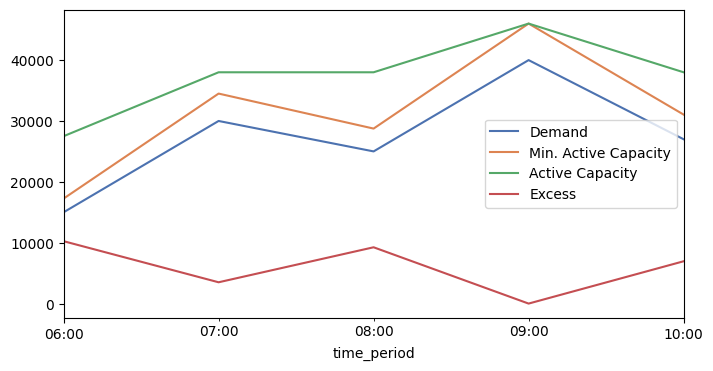

In [50]:
import seaborn as sns

sns.set_palette(sns.color_palette("deep"))

model.optimize()
plt.figure(figsize=(8, 4))
pd.DataFrame(
    {
        "Demand": time_period_data["expected_demand"],
        "Min. Active Capacity": time_period_data["minimum_active_capacity"],
        "Active Capacity": active_capacity.gppd.get_value(),
        "Excess": (-active_capacity_constraint.gppd.Slack),
    }
).plot.line(ax=plt.gca());

In [40]:
#model.close()
#env.close()

In [44]:
fig

NameError: name 'fig' is not defined

In [45]:
ax

NameError: name 'ax' is not defined

In [48]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
